In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


%matplotlib inline

The Idea
===

Find roughly the complexity (average, worst, best) of an algorithm given it's code and input space distribution.  

Methodology
---

Monte Carlo. Take as many possible samplings from input space distribution and shove them into the algorithm. Find the distribution of `time measure` taken.


What is the time measure?
---

The costly operations in your algorithm. For simple algorithms like sorting, we take comparison as the time measure. Thus your implementation should help us track this via a function call to an object, `costly.increment()`. For something like binary search or sorting algorithms, we call this function everytime we do a comparison.

Drawbacks
---

The measure for best and worst case will be noisy. This is because some algorithms have very specific cases where they perform horribly, which can be improbable to obtain from the probability distribution.

For example, if we need to know that Quick Sort (with pivot as the first element of subarray) has worst case $O(N^2)$, we would need to encounter the sample where the array is completely sorted. That would lead to a very poor decrease in problem size in each iteration, effectively something like $T(N) = T(n-1) + O(N)$. Oops. So much for harnessing luck, bad quicksort :P.

Since we're in Monte Carlo, the probabilty of encountering a completely sorted array is $\frac{2}{N!}$. Clearly, it is highly improbable we'll find the case where quick sort (bad quick sort, in this case) will show this behaviour. Another question arises. How accurate is the worst case behaviour estimate given that we know the probability of it showing up? More Monte Carlo? :P

Therefore, mostly we will get a good estimate of the average case only. And that too, if we have a large $N$, a good input space approximation, and a ton of samples from the space.

But well. Anything to avoid putting pen to paper and analysing the algorithm myself :P

Some utilities
===

In [11]:
class CostCounter:
    def __init__(self):
        self.count = 0
    
    def increment(self):
        self.count += 1

A walk through of binary search analysed via Monte Carlo
===



In [12]:
# The user provides all these functions. Self explanatory.
import math


def generate_input_sample(params):
    """
    We generate a random array, and pick a random thing from it. We're only analysing
    the space where the input is actually present in the array. You can DIY a function
    that generates a space where this does not hold true. Best of luck selecting
    hyperparams though.

    How often is the target element not in the search space? This question will tilt
    your average case complexity estimate. So we choose to set it to zero.
    Yeah sue me.
    """
    arr = np.random.randint(params["N"], size=params["N"])+1
    arr = np.sort(arr)
    target = np.random.choice(arr)

    return (arr, target)


# Since the element is always present in the array, we have no
# checks for non-presence case
def actual_binary_search(arr, start, end, target, costly):
    costly() # Count each call to this function as a costly operation
    mid = math.floor((start+end)/2)
    
    if arr[mid] == target:
        return mid

    if arr[mid] > target:
        return actual_binary_search(arr, start, mid-1, target, costly)

    return actual_binary_search(arr, mid+1, end, target, costly)    


def binary_search(input_sample, costly):
    array, target = input_sample
    n = array.size

    return actual_binary_search(array, 0, n-1, target, costly)


Testing our implementation of binary search and counting iterations
===

In [13]:
sample = generate_input_sample({"N": 100})
sample

(array([ 1,  2,  3,  3,  4,  4,  5,  6,  7,  9,  9, 10, 16, 16, 18, 19, 21,
        22, 24, 25, 25, 26, 26, 26, 27, 28, 28, 31, 32, 32, 32, 36, 38, 40,
        41, 45, 45, 45, 46, 46, 47, 48, 48, 48, 49, 51, 51, 52, 53, 55, 59,
        60, 60, 61, 62, 63, 64, 65, 66, 66, 66, 66, 67, 67, 68, 69, 69, 70,
        71, 72, 73, 73, 74, 74, 75, 76, 78, 78, 79, 79, 82, 83, 86, 86, 86,
        87, 87, 87, 88, 88, 89, 89, 91, 92, 93, 96, 96, 96, 97, 99]), 66)

In [14]:
cost_count = CostCounter()
binary_search(sample, cost_count.increment)

61

In [15]:
cost_count.count

3

Monte Carlo, we are here
===

In [43]:
# HYPERPARAMETER ALERT!
NUMBER_OF_SAMPLES = 1000


def get_t_n(n):
    counts = []

    # Generate a data set, crunch it, record the frequency
    for i in range(NUMBER_OF_SAMPLES):
        sample = generate_input_sample({ "N": n })
        cost_count = CostCounter()

        binary_search(sample, cost_count.increment)
        counts.append(cost_count.count)

    # Return average number of operations that happened
    return np.mean(counts), counts

In [44]:
%%time

t_n, counts = get_t_n(1000) # Get T(1000)
t_n, counts[:10]

CPU times: user 206 ms, sys: 3.09 ms, total: 209 ms
Wall time: 208 ms


(8.176, [8, 9, 9, 8, 10, 10, 8, 10, 10, 8])

Histogram of `time measure` taken
===

(array([  6.,   4.,   8.,  10.,  26.,  68., 133., 252., 306., 187.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

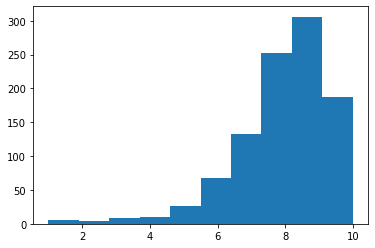

In [33]:
plt.hist(counts)

Analysis
---

Clearly there is a high tendency to take basically ~8 calls to terminate.
From theory we know we should take at max around $log_{2}(1000)$ which is (by ceiling) $10$ so we are on the right track. Woo hoo!

In [34]:
np.max(counts), np.mean(counts)

(10, 8.187)

Obtaining $T(N)$ dataset
===

In [121]:
# Obtain T(N) for a fixed N set
MIN_N = 50
MAX_N = 500

def get_t_n_dataset(min_n, max_n):
    n_arr = []
    t_n = []
    for n in range(min_n, max_n+1):
        print(f"At {n}")
        estimate, counts = get_t_n(n)
        n_arr.append(n)
        t_n.append(estimate)
    
    return n_arr, t_n

n_arr, t_n = get_t_n_dataset(MIN_N, MAX_N)
t_n[:10]

At 50
At 51
At 52
At 53
At 54
At 55
At 56
At 57
At 58
At 59
At 60
At 61
At 62
At 63
At 64
At 65
At 66
At 67
At 68
At 69
At 70
At 71
At 72
At 73
At 74
At 75
At 76
At 77
At 78
At 79
At 80
At 81
At 82
At 83
At 84
At 85
At 86
At 87
At 88
At 89
At 90
At 91
At 92
At 93
At 94
At 95
At 96
At 97
At 98
At 99
At 100
At 101
At 102
At 103
At 104
At 105
At 106
At 107
At 108
At 109
At 110
At 111
At 112
At 113
At 114
At 115
At 116
At 117
At 118
At 119
At 120
At 121
At 122
At 123
At 124
At 125
At 126
At 127
At 128
At 129
At 130
At 131
At 132
At 133
At 134
At 135
At 136
At 137
At 138
At 139
At 140
At 141
At 142
At 143
At 144
At 145
At 146
At 147
At 148
At 149
At 150
At 151
At 152
At 153
At 154
At 155
At 156
At 157
At 158
At 159
At 160
At 161
At 162
At 163
At 164
At 165
At 166
At 167
At 168
At 169
At 170
At 171
At 172
At 173
At 174
At 175
At 176
At 177
At 178
At 179
At 180
At 181
At 182
At 183
At 184
At 185
At 186
At 187
At 188
At 189
At 190
At 191
At 192
At 193
At 194
At 195
At 196
At 197
At 198
At 199


[4.231, 4.095, 4.236, 4.161, 4.268, 4.191, 4.272, 4.3, 4.184, 4.274]

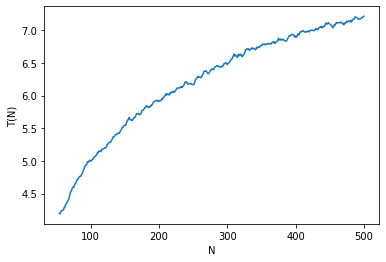

In [122]:
# Smoothen line by taking 5 period moving average

t_n2 = pd.Series(t_n)
t_n2 = t_n2.rolling(5).mean()

plt.plot(n_arr, t_n2)
plt.ylabel("T(N)")
plt.xlabel("N")
plt.show()

Analysis
---

Clearly its a $ log_{2}(N) $ plot that's scaled. It works!
If you can afford the compute, increase the `NUMBER_OF_SAMPLES` variable to something like 10k, you will see an ultra smooth graph.

I will parallelize this code soon, so that's an increase of `however_many_cores_your_pc_has` times in performance to be expected